In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from scipy.stats import binom
from scipy.special import comb
from scipy.stats import binom_test
from scipy.stats import norm

In [4]:
def load_predictions(path, n=5):
    preds = []
    for i in range(n):
        preds.append(pd.read_csv(path.format(i), index_col=0))
    preds = pd.concat(preds).groupby(level=0).mean()    
    return preds

from labels, create signs:  
model1 correct, model2 incorrect -> +  
model1 incorrect, model2 correct -> -
model1 correct/incorrect, model2 correct/incorrect -> =

In [5]:
def signs_from_preds(labels1, labels2, y_true):
    signs = []
    for i in range(len(y_true)):
        if labels1.iloc[i] == y_true.iloc[i]:
            if labels2.iloc[i] == y_true.iloc[i]:
                # both correct
                signs.append(0)
            else:
                # only model 1 correct
                signs.append(-1)
        else:
            if labels2.iloc[i] != y_true.iloc[i]:
                # both wrong
                signs.append(0)
            else:
                # only model 2 correct
                signs.append(1)
    return signs

In [6]:
def sign_test(signs, tie_handling, alpha=.05, p_coin=.5):
    n_ties = (signs == 0).sum()
    n_plus = (signs == 1).sum()
    n_minus = (signs == -1).sum()
    n = len(signs)
    n_without_ties = n - n_ties

    p_coin = 1/2
    if tie_handling == "ignore":
        # taken from paper: Another Look at the Sign Test When Ties Are Present: The Problem of Confidence Intervals
        return binom_test(x=n_plus, n=n_without_ties, p=p_coin)
    
    elif tie_handling == "equal split":
        # taken from paper: Another Look at the Sign Test When Ties Are Present: The Problem of Confidence Intervals
        n_plus_half_ties = n_plus + n_ties / 2
        n_minus_half_ties = n_minus + n_ties / 2
        n = n_plus_half_ties + n_minus_half_ties
        return binom_test(x=n_plus_half_ties, n=n, p=p_coin)
    
    else:
        assert tie_handling == "coin flips"
        # taken from paper: Another Look at the Sign Test When Ties Are Present: The Problem of Confidence Intervals
        coin_flips = np.random.choice([1, -1], size=n_ties, p=[1-p_coin, p_coin])        
        n_plus_coin_flips = n_plus + (coin_flips == 1).sum()
        n_minus_coin_flips = n_minus + (coin_flips == -1).sum()
        n = n_plus_coin_flips + n_minus_coin_flips
        return binom_test(x=n_plus_coin_flips, n=n, p=p_coin)

In [7]:
deep_preds = load_predictions("../results/networks/deep/pathological/eval/predictions_test_{}.csv")
deep_y_true = deep_preds["true_pathological"]
deep_preds = deep_preds["non-pathological"] <= deep_preds["pathological"]
assert len(deep_preds) == len(deep_y_true)

In [8]:
shallow_preds = load_predictions("../results/networks/shallow/pathological/eval/predictions_test_{}.csv")
shallow_y_true = shallow_preds["true_pathological"]
shallow_preds = shallow_preds["non-pathological"] <= shallow_preds["pathological"]
assert len(shallow_preds) == len(shallow_y_true)

In [9]:
tcn_preds = load_predictions("../results/networks/tcn/pathological/eval/predictions_test_{}.csv")
tcn_y_true = tcn_preds["true_pathological"]
tcn_preds = tcn_preds["non-pathological"] <= tcn_preds["pathological"]
assert len(tcn_preds) == len(tcn_y_true)

In [10]:
eegnet_preds = load_predictions("../results/networks/eegnet/pathological/eval/predictions_test_{}.csv")
eegnet_y_true = eegnet_preds["true_pathological"]
eegnet_preds = eegnet_preds["non-pathological"] <= eegnet_preds["pathological"]
assert len(eegnet_preds) == len(eegnet_y_true)

In [11]:
rf_preds = pd.read_csv("../results/features/rf/pathological/without_age_and_gender/eval/predictions_eval.csv", index_col=0).groupby("group").mean()
rf_y_true = rf_preds["y_true"]
rf_preds = .5 <= rf_preds["y_pred"]
assert len(rf_preds) == len(rf_y_true)

In [12]:
svm_preds = pd.read_csv("../results/features/svm/pathological/eval/predictions_eval.csv", index_col=0).groupby("group").mean()
svm_y_true = svm_preds["y_true"]
svm_preds = .5 <= svm_preds["y_pred"]
assert len(svm_preds) == len(svm_y_true)

In [13]:
asc_preds = load_predictions("../results/features/asc/pathological/probas_eval_{}.csv")
asc_preds = .5 <= asc_preds["1"]
assert len(asc_preds) == len(deep_preds)

In [14]:
riemanniam_preds = pd.read_csv("../results/features/riemannian/pathological/eval/predictions_eval.csv", index_col=0)
riemanniam_preds = .5 <= riemanniam_preds["y_pred"]
assert len(riemanniam_preds) == len(deep_preds)

In [15]:
preds_dict = {
    "RF": rf_preds, 
    "SVM": svm_preds, 
    "BD-Deep4": deep_preds, 
    "BD-Shallow": shallow_preds, 
    "BD-EEGNet": eegnet_preds, 
    "BD-TCN": tcn_preds, 
    "ASC": asc_preds, 
    "RG": riemanniam_preds}

In [16]:
# check that network and feature ground truths are the same
for ix, l in enumerate(deep_y_true):
    assert rf_y_true[ix] == l
y_true = deep_y_true

In [17]:
models = ["BD-Deep4", "BD-Shallow", "BD-TCN", "BD-EEGNet", "RF", "SVM", "ASC", "RG"]
columns=["tie_handling", "model1", "model2", "result", "n_ties", "n_plus", "n_minus"]
df = pd.DataFrame(columns=columns)
for i, model1 in enumerate(models):
    for model2 in models[i+1:]:
        signs = signs_from_preds(preds_dict[model1], preds_dict[model2], y_true)
        signs = np.array(signs)
        
        #tie_handling = "ignore"
        #df = df.append(pd.DataFrame([[tie_handling, model1, model2, sign_test(signs, tie_handling=tie_handling), 
        #                              (signs==0).sum(), (signs==1).sum(), (signs==-1).sum()]], columns=columns), ignore_index=True)
        tie_handling = "equal split"
        df = df.append(pd.DataFrame([[tie_handling, model1, model2, sign_test(signs, tie_handling=tie_handling), 
                                      (signs==0).sum(), (signs==1).sum(), (signs==-1).sum()]], columns=columns), ignore_index=True)
        #tie_handling = "coin flips"
        #df = df.append(pd.DataFrame([[tie_handling, model1, model2, sign_test(signs, tie_handling=tie_handling)]], columns=columns), ignore_index=True)

In [18]:
df.sort_values("tie_handling")

,tie_handling,model1,model2,result,n_ties,n_plus,n_minus
0,equal split,BD-Deep4,BD-Shallow,0.952016,266,4,6
25,equal split,SVM,ASC,0.588080,243,22,11
24,equal split,RF,RG,0.856740,245,18,13
23,equal split,RF,ASC,0.952016,264,7,5
22,equal split,RF,SVM,0.588080,241,13,22
21,equal split,BD-EEGNet,RG,0.952016,245,17,14
20,equal split,BD-EEGNet,ASC,1.000000,252,12,12
19,equal split,BD-EEGNet,SVM,0.507966,251,7,18
18,equal split,BD-EEGNet,RF,0.952016,250,12,14
17,equal split,BD-TCN,RG,0.952016,249,13,14


In [19]:
models = ["BD-Deep4", "BD-Shallow", "BD-TCN", "BD-EEGNet", "RF", "SVM", "RG", "ASC"]
ps = np.zeros(shape=(len(models), len(models)))
ts = np.zeros(shape=(len(models), len(models)))
plus = np.zeros(shape=(len(models), len(models)))
minus = np.zeros(shape=(len(models), len(models)))
for i in range(len(df)):
    m1_i = models.index(df.iloc[i]["model1"])
    m2_i = models.index(df.iloc[i]["model2"])
    ps[m1_i][m2_i] = df.iloc[i]["result"]
    ps[m2_i][m1_i] = df.iloc[i]["result"] 
    ps[m1_i][m1_i] = 1       
    ps[m2_i][m2_i] = 1        
    
    ts[m1_i][m2_i] = df.iloc[i]["n_ties"]
    ts[m2_i][m1_i] = df.iloc[i]["n_ties"]   
    ts[m1_i][m1_i] = 1       
    ts[m2_i][m2_i] = 1     
    
    plus[m1_i][m2_i] = df.iloc[i]["n_plus"]
    plus[m2_i][m1_i] = df.iloc[i]["n_plus"]   
    plus[m1_i][m1_i] = 1       
    plus[m2_i][m2_i] = 1   
    
    minus[m1_i][m2_i] = df.iloc[i]["n_minus"]
    minus[m2_i][m1_i] = df.iloc[i]["n_minus"]   
    minus[m1_i][m1_i] = 1       
    minus[m2_i][m2_i] = 1   

In [20]:
import matplotlib
fs = 16
matplotlib.rcParams.update({'font.size': fs})

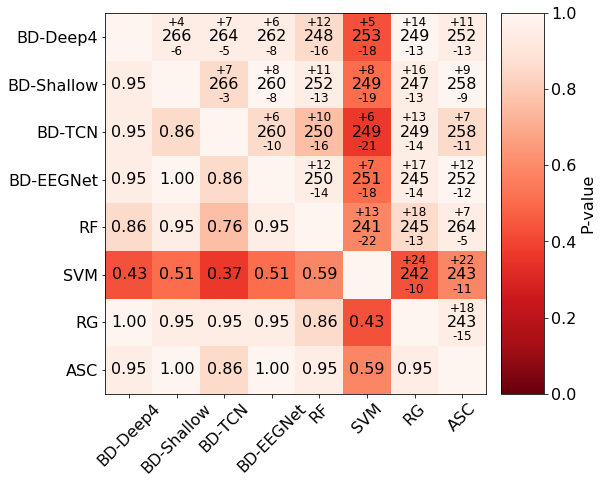

In [21]:
fig, ax = plt.subplots(figsize=(12,7))
ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, rotation=45)
ax.set_yticks(range(len(models)))
ax.set_yticklabels(models)
im = ax.imshow(ps, cmap="Reds_r")
fig.subplots_adjust(right=1.1)
cbar_ax = fig.add_axes([0.85, 0.125, 0.05, 0.755])
cbar = fig.colorbar(im, cax=cbar_ax)
im.set_clim([0,1])
cbar.ax.set_ylabel("P-value");

for i in range(len(models)):
    for j in range(i+1, len(models)):
        c = "k" if ps[i][j] > .05 else "w"
        ax.text(i, j, "{:.2f}".format(ps[i,j]), va="center", ha="center", color=c)
        #ax.text(j, i+.2, "$-{:.0f}$".format(minus[j,i]), va="center", ha="center", color=c, fontsize=18)
        ax.text(j, i+.3, "-{:.0f}".format(minus[j,i]), va="center", ha="center", color=c, fontsize=fs-4)
        ax.text(j, i, "{:.0f}".format(ts[j,i]), va="center", ha="center", color=c, fontsize=fs)
        ax.text(j, i-.3, "+{:.0f}".format(plus[j,i]), va="center", ha="center", color=c, fontsize=fs-4)
        #ax.text(j, i-.2, "$+{:.0f}$".format(plus[j,i]), va="center", ha="center", color=c, fontsize=18)